In [1]:
import ProbForecastFollmerProcess as pffp
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.distributions import MultivariateNormal
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Computing on ' + str(device))

Computing on cuda


In [2]:
# reproducibility
SEED = 1024
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = True  
torch.manual_seed(SEED)  
np.random.seed(SEED)  
random.seed(SEED)

In [19]:
# defining number of dimensions
dim = 2

# defining base gaussian component
mean_0 = torch.tensor([5.0, 0.0], device = device)
cov_0 = torch.tensor([[1.5, 0.0], [0.0, 0.1]], device = device)

# defining number of mixture models
K = 5

# defining lag
tau_mul = 1 # 3 4

# defining rotation angle
theta = torch.tensor([2.0*np.pi/K], device = device)

# defining rotation matrix
R_theta = lambda k: torch.tensor([[torch.cos(k*theta), -torch.sin(k*theta)], [torch.sin(k*theta), torch.cos(k*theta)]], device = device)
rotations = [R_theta(k) for k in range(K)]

# defining mixture
gmm_params = [{"mean": torch.matmul(R, mean_0), "cov": torch.matmul(torch.matmul(R, cov_0), R.T)} for R in rotations]
print(gmm_params)
gmm_components = [MultivariateNormal(params["mean"], params["cov"]) for params in gmm_params]

# defining function for computing gradient of gaussian log pdf
def grad_log_pdf(x, pdf):
    x_ = x.clone().detach().requires_grad_(True)
    y = pdf.log_prob(x_.to(device))
    y.retain_grad()
    y.backward()
    return x_.grad

# function for plotting densities heatmap
def plot_density(x, y, fig, axes, title = "", bins = 200):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    axes.imshow(heatmap.T, extent=extent, origin='lower', cmap = "grey")
    axes.set_title(title)

[{'mean': tensor([5., 0.], device='cuda:0'), 'cov': tensor([[1.5000, 0.0000],
        [0.0000, 0.1000]], device='cuda:0')}, {'mean': tensor([1.5451, 4.7553], device='cuda:0'), 'cov': tensor([[0.2337, 0.4114],
        [0.4114, 1.3663]], device='cuda:0')}, {'mean': tensor([-4.0451,  2.9389], device='cuda:0'), 'cov': tensor([[ 1.0163, -0.6657],
        [-0.6657,  0.5837]], device='cuda:0')}, {'mean': tensor([-4.0451, -2.9389], device='cuda:0'), 'cov': tensor([[1.0163, 0.6657],
        [0.6657, 0.5837]], device='cuda:0')}, {'mean': tensor([ 1.5451, -4.7553], device='cuda:0'), 'cov': tensor([[ 0.2337, -0.4114],
        [-0.4114,  1.3663]], device='cuda:0')}]


In [ ]:
# settings of the simulation
delta_t = torch.tensor([1e-2], device = device)
observation_interval = 5
Delta_t = torch.tensor([delta_t * observation_interval], device = device)

# defining number of observations and iterations
num_iters = int(1e5) 
num_observations = int(num_iters / observation_interval)

# defining the store for the states and observations
state_store = torch.zeros((num_iters, dim))
observation_store = torch.zeros((num_observations, dim))

# sampling the first state and storing it
X = gmm_components[0].sample()
state_store[0, :] = X
observation_store[0, :] = X

# rate of the poisson process
poisson_rate = torch.tensor([2.0], device = device)
num_rotations = 0

# progress bar
time = tqdm(range(num_iters))


# running the simulation
for t in range(num_iters):
    # sampling noise and scaling it
    xi = torch.randn(2, device = device)
    noise = torch.sqrt(2*delta_t)*xi

    # retrieving pdf of mixture component
    current_rotation = num_rotations%K
    pdf = gmm_components[current_rotation]

    # computing gradient of log likelihood and scaling it
    grad_p = grad_log_pdf(X, pdf)
    grad_p = grad_p * delta_t

    # computing the update
    X = X + grad_p + noise

    # sampling the rotation
    flag = torch.rand(1, device = device)
    if flag < poisson_rate*delta_t:
        num_rotations += 1
        X = torch.matmul(R_theta(1),X)

    # saving the states to the store
    state_store[t, :] = X
    if t%observation_interval == 0:
        index = t // observation_interval
        observation_store[index, :] = X
    time.update()

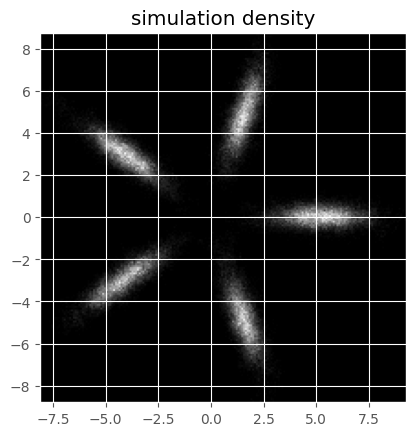

In [15]:
# defining figure and axes
fig, axes = plt.subplots()

# plotting the simulated dynamics
x = state_store[:,0].detach().cpu()
y = state_store[:,1].detach().cpu()
plot_density(x, y, fig, axes, "simulation density")

In [5]:
# defining sampling function
def sample_observations(N):
    indexes = torch.randint(0, num_observations - tau_mul, size = (N,))
    current_state= observation_store[indexes, :].to(device)
    next_state = observation_store[indexes + tau_mul, :].to(device)
    return current_state, next_state
    
# defining custom follmer process
def g_follmer(s):
    sigma = interpolant["sigma"](s)
    beta = interpolant["beta"](s)
    beta_dot = velocity["beta_dot"](s)
    sigma_dot = velocity["sigma_dot"](s)
    g = 2*s*sigma*(beta_dot*sigma/beta - sigma_dot) - sigma**2
    g = torch.abs(g)
    g = torch.sqrt(g)
    return g

In [6]:
# defining data configurations
data = {    
    "fun": sample_observations, 
}

# defining sampling confgurations
sample = {
    "g": g_follmer, 
    "N": 1000
}

# learning standardization means and standard deviations
standardization = {
    'state_mean': torch.mean(observation_store, 0).to(device), 
    'state_std': torch.std(observation_store, 0).to(device), 
}
print(standardization)

# defining network configurations
net_config = {
    "layers": [500]*5, 
    "standardization": standardization
}

# defining state configurations 
state = {
    "dim": dim
}

# defining interpolant configurations
interpolant = {
    "alpha": lambda s: 1 - s,
    "beta": lambda s: s**2, # s
    "sigma": lambda s: 1 - s
}

# defining velocity configurations
velocity = {
    "alpha_dot": lambda s: -1,
    "beta_dot": lambda s: 2*s, # 1
    "sigma_dot": lambda s: -1
}

# defining optimization configurations
I = 300
optim_config = {
    'minibatch': 1, 
    'num_obs_per_batch': 1000, 
    'num_iterations': I,
    'learning_rate' : 0.001,
    'num_mc_samples': 100 
}

# defining model
model = pffp.core.model(data, sample, state, interpolant, velocity, net_config, device = "cuda")

# training model
model.train(optim_config)

{'state_mean': tensor([0.1123, 0.1285], device='cuda:0'), 'state_std': tensor([3.7285, 3.6742], device='cuda:0')}
Optimization iteration: 1 Loss: 6.735998153686523
Optimization iteration: 50 Loss: 1.1288836002349854
Optimization iteration: 100 Loss: 0.8158566951751709
Optimization iteration: 150 Loss: 0.65683913230896
Optimization iteration: 200 Loss: 0.7262367606163025
Optimization iteration: 250 Loss: 0.6585884094238281
Optimization iteration: 300 Loss: 0.6914210915565491


In [7]:
# sampling configuration
sample_config = {
    "minibatch": 1, 
    "num_obs_per_batch": 1000,
    "num_samples_per_obs": 1
}

# running sampling
(X0, X1), samples = model.sample(sample_config)
print(f"{X0.shape=}, {X1.shape=}, {samples.shape=}")

X0.shape=torch.Size([1000, 2]), X1.shape=torch.Size([1000, 2]), samples.shape=torch.Size([1, 1000, 2])


/tmp/ipykernel_18614/2958705664.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


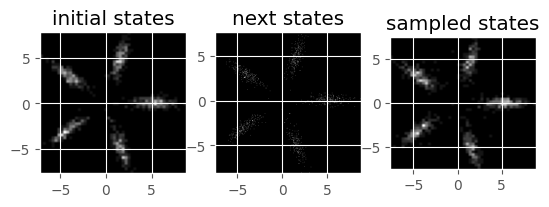

In [21]:
%matplotlib inline
# retrieving the data
x_hat, y_hat = samples[0, :, 0].detach().cpu(), samples[0,:,1].detach().cpu()
x0, y0 = X0[:, 0].detach().cpu(), X0[:, 1].detach().cpu()
x1, y1 = X1[:, 0].detach().cpu(), X1[:, 1].detach().cpu()

# defining axes and figure
fig, axes = plt.subplots(1, 3)

# plotting the distributions
plot_density(x0, y0, fig, axes[0], title = "initial states", bins = 50)
plot_density(x1, y1, fig, axes[1], title = "next states")
plot_density(x_hat, y_hat, fig, axes[2], title = "sampled states", bins = 50)
fig.show()

/tmp/ipykernel_18614/1435331821.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


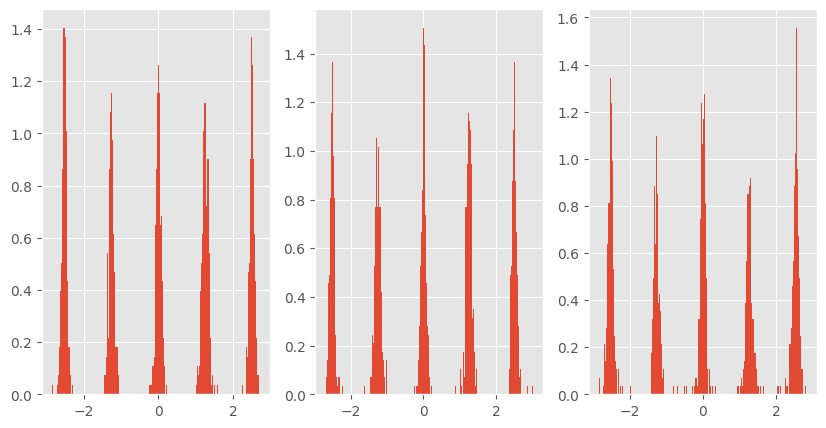

In [36]:
# function for getting the angular representation of a vector
def vec2angle(x, y):
    # normalize vectors
    norm = torch.sqrt(x**2 + y**2)
    x_, y_ = x/norm, y/norm
    # computing angle
    theta = torch.arctan2(y_, x_)
    return theta

# converting to angular coordinates
theta_0 = vec2angle(x0,y0)
theta_1 = vec2angle(x1,y1)
theta_hat = vec2angle(x_hat,y_hat)

# defining figure and axes
fig, axes = plt.subplots(1, 3, figsize = (10, 5))

# plotting the angular distributions
hist0 = axes[0].hist(theta_0, density = True, bins = 200)
hist1 = axes[1].hist(theta_1, density = True, bins = 200)
hist_hat = axes[2].hist(theta_hat, density = True, bins = 200)

# showing the figure
fig.show()